In [1]:
from src.paths import QSD2_W2_PATH, WEEK_2_RESULTS_PATH
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from PIL import Image
import seaborn as sns
import pandas as pd
import cv2

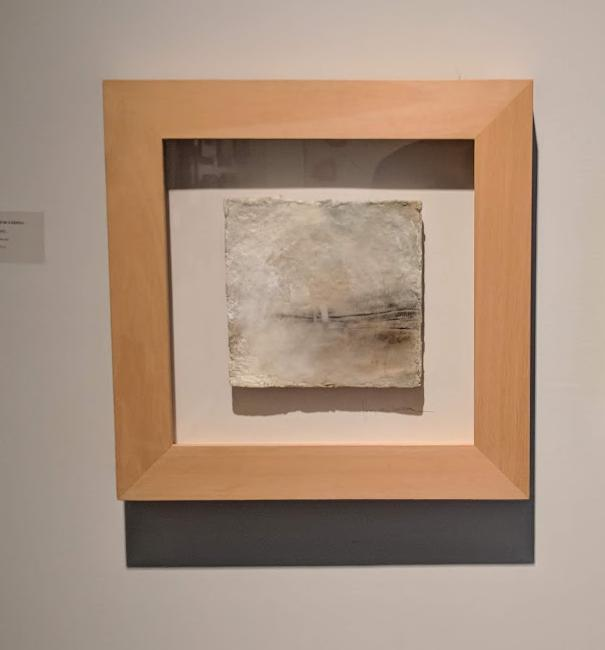

In [2]:
# Query image descriptors

query_image_PIL_list = [Image.open(query_img_path) for query_img_path in sorted(QSD2_W2_PATH.glob("*.jpg"))]
query_image_PIL = query_image_PIL_list[0]
query_image_PIL

In [17]:
def plot_image_channels(query_image_PIL, filename):
    # Assuming query_image_PIL is the input PIL Image
    # Convert the image to different color spaces and split the channels
    color_spaces = {
        'RGB': query_image_PIL.split(),  # RGB channels
        'HSV': query_image_PIL.convert('HSV').split(),
        'LAB': query_image_PIL.convert('LAB').split(),
        'YCbCr': query_image_PIL.convert('YCbCr').split()
    }
    
    # Setup the plot
    fig, axes = plt.subplots(5, 3, figsize=(12, 12))
    
    # Function to plot each channel with colorbar
    def plot_channel(ax, channel, title):
        im = ax.imshow(np.array(channel), cmap='gray')
        ax.set_title(title)
        ax.axis('off')
        fig.colorbar(im, ax=ax)
    
    # Plot the original image
    axes[0, 1].imshow(query_image_PIL)
    axes[0, 1].set_title('Original Image')
    axes[0, 1].axis('off')
    
    # Flatten axes for easy iteration and plot each color space
    flat_axes = axes[1:].flatten()
    
    # Channel labels for each color space
    channel_labels = ['R', 'G', 'B', 'H', 'S', 'V', 'L', 'A', 'B', 'Y', 'Cb', 'Cr']
    
    for i, (space, channels) in enumerate(color_spaces.items()):
        for j, channel in enumerate(channels):
            plot_channel(flat_axes[i*3 + j], channel, f'{channel_labels[i*3 + j]} ({space})')
    
    # Adjust layout
    plt.tight_layout()
    plt.savefig((WEEK_2_RESULTS_PATH / filename).as_posix())
    plt.close()

for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query_image_PIL_list):
    save_name = query_image_path.name.split(".")[0] + "_channels.png"
    plot_image_channels(query_image_PIL, save_name)


In [18]:
from skimage.filters import threshold_yen, threshold_triangle
import cv2
import numpy as np
import matplotlib.pyplot as plt

def plot_and_save_image_channels(image_PIL, filename, threshold_method='OTSU', use_only_edges=False, blur=False):
    # Define the different channels and their labels
    color_spaces = {
        'RGB': image_PIL.split(),
        'HSV': image_PIL.convert('HSV').split(),
        'LAB': image_PIL.convert('LAB').split(),
        'YCbCr': image_PIL.convert('YCbCr').split()
    }
    
    channel_labels = {
        'RGB': ['R', 'G', 'B'],
        'HSV': ['H', 'S', 'V'],
        'LAB': ['L', 'A', 'B (LAB)'],
        'YCbCr': ['Y', 'Cb', 'Cr']
    }
    
    # Function to apply the chosen thresholding method
    def apply_threshold(channel, method):
        channel = np.array(channel)
        
        if not use_only_edges:
            channel_for_threshold = channel
        else:
            n = 10
            channel_for_threshold = channel[np.r_[0:n, -n:0]][:, np.r_[0:n, -n:0]]
            
        if blur:
            channel_for_threshold = cv2.GaussianBlur(channel_for_threshold, (5, 5), 0)
        
        if method == 'OTSU':
            threshold_value, _ = cv2.threshold(channel_for_threshold, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            thresholded_channel = (channel > threshold_value).astype(np.uint8) * 255
        elif method == 'YEN':
            threshold_value = threshold_yen(channel_for_threshold)
            thresholded_channel = (channel > threshold_value).astype(np.uint8) * 255
        elif method == 'TRIANGLE':
            threshold_value = threshold_triangle(channel_for_threshold)
            thresholded_channel = (channel > threshold_value).astype(np.uint8) * 255
        elif method == 'ADAPTIVE':
            thresholded_channel = cv2.adaptiveThreshold(channel, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                                        cv2.THRESH_BINARY, 11, 2)
        else:
            raise ValueError(f"Unknown thresholding method: {method}")
        
        return thresholded_channel
    
    # Prepare the plot
    plt.figure(figsize=(15, 15))
    
    # Counter for the subplot index
    subplot_idx = 1
    
    # Iterate over each color space and its channels
    for color_space, channels in color_spaces.items():
        labels = channel_labels[color_space]
        
        for channel, label in zip(channels, labels):
            thresholded_channel = apply_threshold(channel, threshold_method)
            plt.subplot(4, 3, subplot_idx)
            plt.title(f'Thresholded {label} Channel - {threshold_method}')
            plt.imshow(thresholded_channel, cmap='gray')
            subplot_idx += 1

    plt.tight_layout()
    plt.savefig((WEEK_2_RESULTS_PATH / filename).as_posix())
    plt.close()

# Usage example with different methods:
for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query_image_PIL_list):
    plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_channels_otsu.png", threshold_method='OTSU'),#plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_channels_otsu_blur.png", threshold_method='OTSU', blur=True)
    #plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_channels_otsu_only_edges.png", threshold_method='OTSU', use_only_edges=True)
    #plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_yen.png", threshold_method='YEN')
    #plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_triangle.png", threshold_method='TRIANGLE')
    #plot_and_save_image_channels(query_image_PIL, f"{query_image_path.stem}_channels_adaptive.png", threshold_method='ADAPTIVE')


In [110]:
import numpy as np
from PIL import Image
from skimage import filters

def classify_image_rgb(query_image_PIL, pctg=0.5):  
    # Get the size of the image
    width, height = query_image_PIL.size
    
    # Calculate the dimensions for cropping
    crop_width = int(pctg * width)
    crop_height = int(pctg * height)
    
    # Calculate the coordinates for the cropped region (centered)
    left = (width - crop_width) // 2
    top = (height - crop_height) // 2
    right = left + crop_width
    bottom = top + crop_height
    crop_box = (left, top, right, bottom)
    
    # Crop the central region
    central_region = query_image_PIL.crop(crop_box)
    
    # Convert the cropped region to a NumPy array
    central_region_rgb = np.array(central_region)
    
    # Convert the RGB image to grayscale for thresholding
    central_region_gray = np.mean(central_region_rgb, axis=2)  # Average the RGB channels
    
    # Compute Otsu's threshold
    otsu_threshold = filters.threshold_otsu(central_region_gray)
    
    # Count dark, neutral, and bright pixels based on RGB values
    dark_threshold = otsu_threshold  # Threshold for dark pixels
    bright_threshold = otsu_threshold  # Threshold for bright pixels
    
    # Define conditions for dark and bright pixels
    dark_pixels = np.all(central_region_rgb <= dark_threshold, axis=-1)  # All RGB channels should be dark
    bright_pixels = np.all(central_region_rgb >= bright_threshold, axis=-1)  # All RGB channels should be bright
    
    # Count dark and bright pixels
    num_dark_pixels = np.sum(dark_pixels)
    num_bright_pixels = np.sum(bright_pixels)
    num_total_pixels = central_region_rgb.shape[0] * central_region_rgb.shape[1]
    
    # Calculate percentages
    dark_percentage = num_dark_pixels / num_total_pixels
    bright_percentage = num_bright_pixels / num_total_pixels
    
    # Classify based on the percentages
    if dark_percentage > 0.50 > bright_percentage:
        return "dark"
    elif bright_percentage > 0.50 > dark_percentage:
        return "bright"
    else:
        return "neutral"

# Example usage with your query images
for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query_image_PIL_list):
    print(f"{query_image_path.stem}: {classify_image_rgb(query_image_PIL)}")

00000: neutral
00001: dark
00002: neutral
00003: neutral
00004: neutral
00005: neutral
00006: neutral
00007: neutral
00008: neutral
00009: neutral
00010: dark
00011: dark
00012: neutral
00013: neutral
00014: neutral
00015: neutral
00016: dark
00017: neutral
00018: neutral
00019: neutral
00020: bright
00021: dark
00022: neutral
00023: neutral
00024: neutral
00025: neutral
00026: dark
00027: neutral
00028: neutral
00029: bright


In [99]:
def apply_otsu_threshold(channel):
    channel = np.array(channel)
    threshold_value, _ = cv2.threshold(channel, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return (channel > threshold_value).astype(np.uint8) * 255

In [100]:
def get_dark_image_channels(image_PIL):
    color_spaces = {
        'RGB': image_PIL.split(),
        'HSV': image_PIL.convert('HSV').split(),
        'LAB': image_PIL.convert('LAB').split(),
        'YCbCr': image_PIL.convert('YCbCr').split()
    }
    
    return np.stack([
        apply_otsu_threshold(color_spaces['LAB'][0]), #L
        apply_otsu_threshold(color_spaces['YCbCr'][0]), #Y
        apply_otsu_threshold(color_spaces['YCbCr'][2]) #Cr
    ])

In [101]:
def get_bright_image_channels(image_PIL):
    color_spaces = {
        'RGB': image_PIL.split(),
        'HSV': image_PIL.convert('HSV').split(),
        'LAB': image_PIL.convert('LAB').split(),
        'YCbCr': image_PIL.convert('YCbCr').split()
    }
    
    return np.stack([
        apply_otsu_threshold(color_spaces['HSV'][1]), #S
        apply_otsu_threshold(color_spaces['LAB'][2]), #B
        apply_otsu_threshold(color_spaces['YCbCr'][2]) #Cr
    ])

In [102]:
def get_neutral_image_channels(image_PIL):
    color_spaces = {
        'RGB': image_PIL.split(),
        'HSV': image_PIL.convert('HSV').split(),
        'LAB': image_PIL.convert('LAB').split(),
        'YCbCr': image_PIL.convert('YCbCr').split()
    }
    
    return np.stack([
        apply_otsu_threshold(color_spaces['HSV'][0]), #H
        apply_otsu_threshold(color_spaces['HSV'][1]), #S
        apply_otsu_threshold(color_spaces['HSV'][2]), #V
        apply_otsu_threshold(color_spaces['LAB'][0]), #L
        apply_otsu_threshold(color_spaces['YCbCr'][0]), #Y
    ])

In [105]:
# if neutral
for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query_image_PIL_list):
    image_classification = classify_image_rgb(query_image_PIL)
    if image_classification == "dark":
        """
        1 -> R,G,B,V,L,Y
        10 -> R,G,B,V,L,Y
        14 -> R,G,B,V,L,Y,Cr (sombra)
        14 -> R,G,B,V,L,Y,Cr (sombra)
        27 -> L
        
        Return L,Y,Cr
        """
        best_image_channels_mask = get_dark_image_channels(query_image_PIL)
    elif image_classification == "bright":
        """
        0 -> S,A,B,Cb,Cr
        7 -> A, B, Cb, Cr
        20 -> S,B,Cr
        
        Return S,B,Cr
        """
        best_image_channels_mask = get_bright_image_channels(query_image_PIL)
    else:
        """
        16 -> 
        17 -> L,Y
        24 -> H,S,V,L,A,B,
        25 -> H,S,V,L,Y
        26 -> A,B,Cb,Cr
        
        Return ???
        """
        best_image_channels_mask = get_neutral_image_channels(query_image_PIL)
    
    # Save the image with selected channels
    # Assuming best_image_channels_mask is in shape (H, W, C)
    num_channels = best_image_channels_mask.shape[0]
    
    fig, axes = plt.subplots(1, num_channels + 1, figsize=(15, 5))
    axes[0].imshow(np.array(query_image_PIL))
    for i in range(num_channels):
        axes[i+1].imshow(best_image_channels_mask[i], cmap='gray')
        axes[i+1].axis('off')
        axes[i+1].set_title(f'Channel {i+1}')

    plt.suptitle(f"{query_image_path.stem}_channels_{image_classification}.png")
    plt.savefig((WEEK_2_RESULTS_PATH / "best" / f"{query_image_path.stem}_channels_{image_classification}.png").as_posix())
    plt.close(fig)

In [111]:
# AIXO ES LO BO!!!!!!

for query_image_path, query_image_PIL in zip(sorted(QSD2_W2_PATH.glob("*.jpg")), query_image_PIL_list):
    image_classification = classify_image_rgb(query_image_PIL)
    if image_classification == "dark":
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('LAB').split()[0]))
    elif image_classification == "bright":
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('LAB').split()[2]))
    else:
        best_image_channel_mask = apply_otsu_threshold(np.array(query_image_PIL.convert('HSV').split()[1]))
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes[0].imshow(np.array(query_image_PIL))
    axes[1].imshow(best_image_channel_mask, cmap='gray')
    axes[1].axis('off')
    axes[1].set_title(f'Channel')

    plt.suptitle(f"{query_image_path.stem}_channels_{image_classification}.png")
    plt.savefig((WEEK_2_RESULTS_PATH / "best_single" / f"{query_image_path.stem}_channels_{image_classification}.png").as_posix())
    plt.close(fig)